# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

# File sorting

`*` matches 0 or more characters.

In [15]:
file_list = glob('/nvme0/fwi-reanalysis/ECMWF_FWI_20*_1200_hr_fwi_e5.nc')

A sample of file names.

In [16]:
file_list[:3]

['/nvme0/fwi-reanalysis/ECMWF_FWI_20200307_1200_hr_fwi_e5.nc',
 '/nvme0/fwi-reanalysis/ECMWF_FWI_20191016_1200_hr_fwi_e5.nc',
 '/nvme0/fwi-reanalysis/ECMWF_FWI_20191206_1200_hr_fwi_e5.nc']

Sorting files by time to get deterministic order after loading.

In [18]:
files = sorted(file_list, key=lambda x: int(x[-22:-20])*100 + int(x[-20:-18]))

*Data is expected to be for 12 months*

In [19]:
len(files)

366

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.

In [20]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-reanalysis')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file. `h5netcdf` engine gives faster I/O compared to the default `netcdf4`.

In [21]:
xr.open_dataset(files[0], engine='h5netcdf')

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jun 03 12:12:44 2020: cdo --silent -select,name=fw...
    Reference date:    20200101
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

Combining multiple files into single dataarray.

In [ ]:
proc = xr.open_mfdataset(files, engine='h5netcdf')

Taking a look.

In [24]:
proc

,Array,Chunk
Bytes,1.20 GB,3.28 MB
Shape,"(366, 640, 1280)","(1, 640, 1280)"
Count,1098 Tasks,366 Chunks
Type,float32,numpy.ndarray


**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>
*Should match with fwi-forcings to not require interpolation*

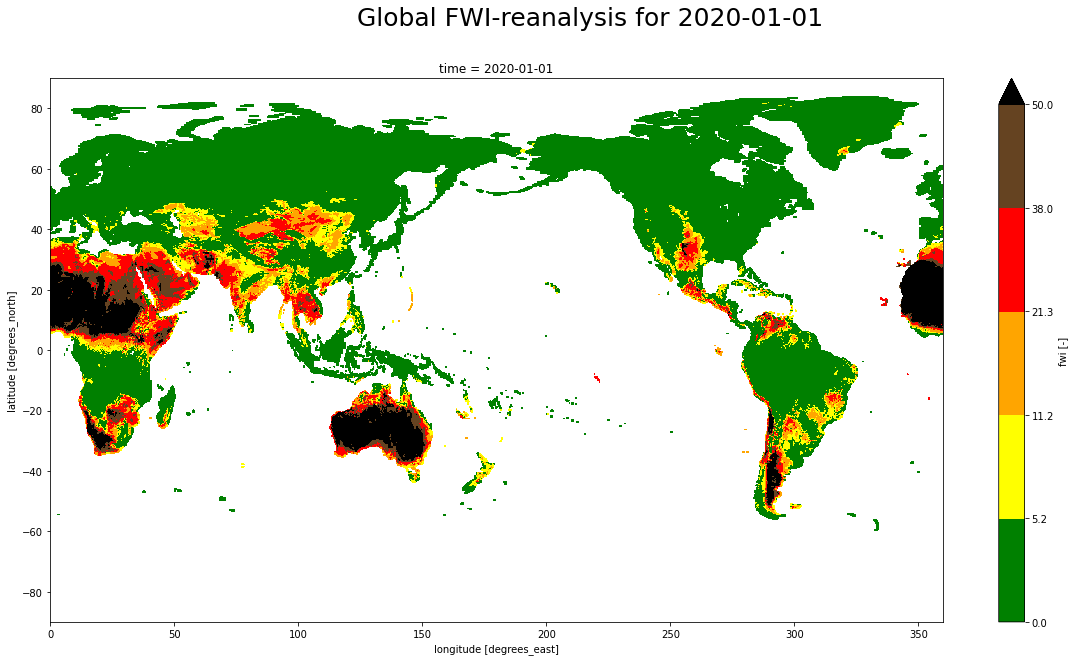

In [14]:
plt.figure(figsize = (20,10)).suptitle('Global FWI-reanalysis for 2020-01-01', fontsize=25)
proc.fwi[0].plot(levels = [0.0, 5.2, 11.2, 21.3, 38.0, 50.0],
                 colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
                 label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'])

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [31]:
np.isnan(proc.fwi[0].values).any()

True

Printing general stats. During calculation, the NaN values are skipped using `skipna` parameter.

In [32]:
def stats(x):
    tmp = x.mean(skipna=True).values
    print('mean', tmp)
    print('mad', abs(x-tmp).mean(skipna=True).values)
    print('var', x.var(skipna=True).values)
    print('min', x.min(skipna=True).values)
    print('max', x.max(skipna=True).values)

In [33]:
stats(proc.fwi)

mean 15.292629
mad 18.819166
var 621.65894
min 1.7216163e-09
max 304.7236
